# Generating Expected Threat (xT) 

## Introduction

Welcome to this Jupyter Notebook, where we delve into the exciting world of Expected Threat (xT) metrics in the context of football (soccer) analytics. The concept of Expected Threat, popularized by Karun Singh and others, provides a powerful framework for quantifying the potential threat posed by a team or player in different regions of the field.

Expected Threat is a statistical metric that assigns a numerical value to each location on the pitch, reflecting the likelihood of a goal being scored in the same possession based on historical data. This metric is helpfull for gaining insights into team strategies, player performance, and overall match dynamics.

The notebook is a showcase of how the xT in the `databallpy` package is calculated. However, it is closely based on the work and blog of Karun Singh (see the article [here](https://karun.in/blog/expected-threat.html))

## What to Expect

1. **Data Loading:** We will start by loading football event data into our Jupyter environment. The dataset will serve as the foundation for our xT calculations. Note that the data is not publicaly available.

2. **xT Calculation:** We will dive into the mathematical foundations of Expected Threat, discussing how to compute xT values for various events on the field. You'll gain insights into the factors influencing threat levels and how to model them effectively.

3. **Visualization:** Effective visualization is key to understanding and communicating xT metrics. We'll explore different plotting techniques to represent xT values spatially on the football pitch.

In [1]:
import pandas as pd
from databallpy.visualize import plot_soccer_pitch
from databallpy.features.angle import get_smallest_angle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import joblib
import matplotlib.patches as mpatches


## Read in the Dataset

The used data to create this model is non-public data. It contains event data of over 600 matches. For every on-ball event (pass, shot, or dribble) we indicate whether it was successful, what the start location was of the event, and for passes and dribbles, what the end location of the event was if the event was successful. Note that all events are normalised so that the goal is to score on the right side of the pitch.

In [2]:
df = pd.read_pickle("positions_goals_dataset.pkl") # note this is a local dataset

# exclude own goals and goals scored from own half, probably an event data error
df = df[df["event"]!="own_goal"]
df = df[~((df["event"]=="shot") & (df["successful"]==1) & (df["start_x"] < 0))]

## Define Constants

Now we will define the constants for the grid over the pitch, and the size of the pitch

In [24]:
N_X_BINS = 32
N_Y_BINS = 24
X_RANGE = (-53, 53)
Y_RANGE = (-34, 34)
pitch_length = (X_RANGE[1] - X_RANGE[0]) / N_X_BINS
pitch_width = (Y_RANGE[1] - Y_RANGE[0]) / N_Y_BINS

## Visualisations of Dataset

Now it's important to check what are data actually looks like. In the next part we will look at the success rate of all actions, shots, and where on the pitch these actions happen.

In [25]:
params = {"bins": (N_X_BINS, N_Y_BINS), "range": [X_RANGE, Y_RANGE]}

hist_events, x_edges, y_edges = np.histogram2d(df['start_x'], df['start_y'], **params)
hist_shots, _, _ = np.histogram2d(df.loc[df["event"]=="shot", 'start_x'], df.loc[df["event"]=="shot", 'start_y'], **params)
hist_goals, _, _ = np.histogram2d(
    df.loc[((df["event"]=="shot") & (df["successful"]==1)), 'start_x'], 
    df.loc[((df["event"]=="shot") & (df["successful"]==1)), 'start_y'], 
    **params
) 
hist_ball_moves, _, _ = np.histogram2d(df.loc[df["event"]!="shot", 'start_x'], df.loc[df["event"]!="shot", 'start_y'], **params)
hist_ball_moves_succ, _, _ = np.histogram2d(
    df.loc[((df["event"]!="shot") & (df["successful"]==1)), 'start_x'], 
    df.loc[((df["event"]!="shot") & (df["successful"]==1)), 'start_y'], 
    **params
)
ratio_shots = np.divide(hist_shots, hist_events, where=hist_events!=0)
ratio_goals = np.divide(hist_goals, hist_shots, where=hist_shots!=0)
ratio_ball_moves = np.divide(hist_ball_moves, hist_events, where=hist_events!=0)
ratio_ball_moves_succ = np.divide(hist_ball_moves_succ, hist_ball_moves, where=hist_ball_moves!=0)
ratio_failed_actions = 1 - (ratio_ball_moves * ratio_ball_moves_succ) - (ratio_shots * ratio_goals)

In [26]:
def plot_results(data, title=None, label=None, add_text=True, add_cbar=True):
    fig, ax = plot_soccer_pitch(pitch_color="white")
    pcm = ax.pcolormesh(x_edges, y_edges, data.reshape(N_X_BINS, N_Y_BINS).T * 100, cmap='viridis', alpha=0.9)
    if add_cbar:
        cbar = plt.colorbar(pcm, ax=ax, label=label)
    ax.set_title(title)

    if add_text:
        for idx in range(len(data)):
            x1 = X_RANGE[0] + (idx // N_Y_BINS) * pitch_length
            y1 = Y_RANGE[0] + (idx % N_Y_BINS) * pitch_width
            ax.text(x=x1 + pitch_length/2, y=y1+pitch_width/2, s=f"{round(data[idx] *100)}", fontsize=7, alpha=0.8, color='black', ha='center', va='center')
    plt.show()

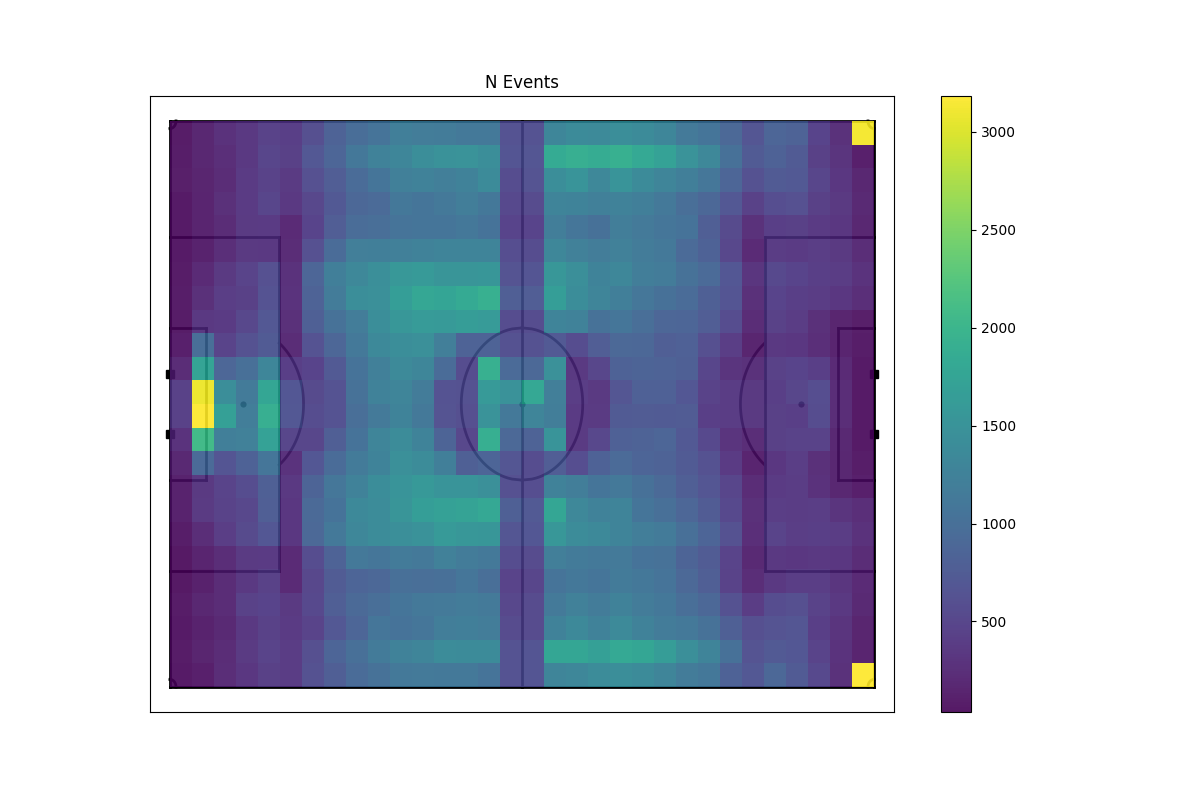

In [27]:
titles = ["N Events", "Percentage Shots of all Events", "Percentage Goals of all Shots", "Percentage Ball Moves of all Events", "Percentage Successful Moves of all Ball Moves"]
ratios = [hist_events, ratio_shots, ratio_goals, ratio_ball_moves, ratio_ball_moves_succ]

# Divide by 100 because it aims to make percentages of it, does not make sence it this case
plot_results(hist_events.ravel()/100., title=titles[0], add_text=False, )

This plot shows for every cell in the grid, the number of events that are happening there. Interestingly, you can see that around the middle line and the circle, less events occur. This has probably to do with a bias in the event data software to place an event in a specified part of the pitch. For now we can not do much about that. Another interesting feature is that you see that the corners and goal kicks are very prevelant, this has obviously to do with the fact that they are quit common set pieces, which are always on the same location on the pitch.

Let's have a look at how the different types of events, and their success rate, are divided over the pitch.

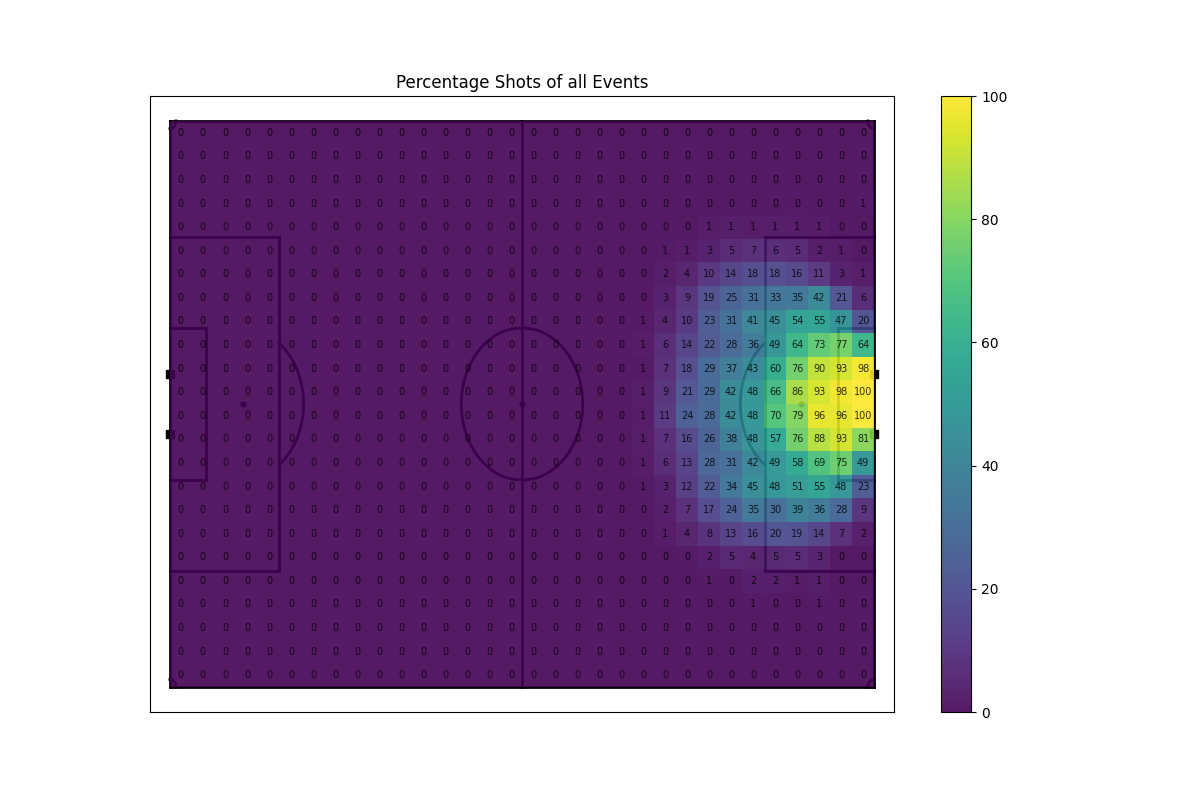

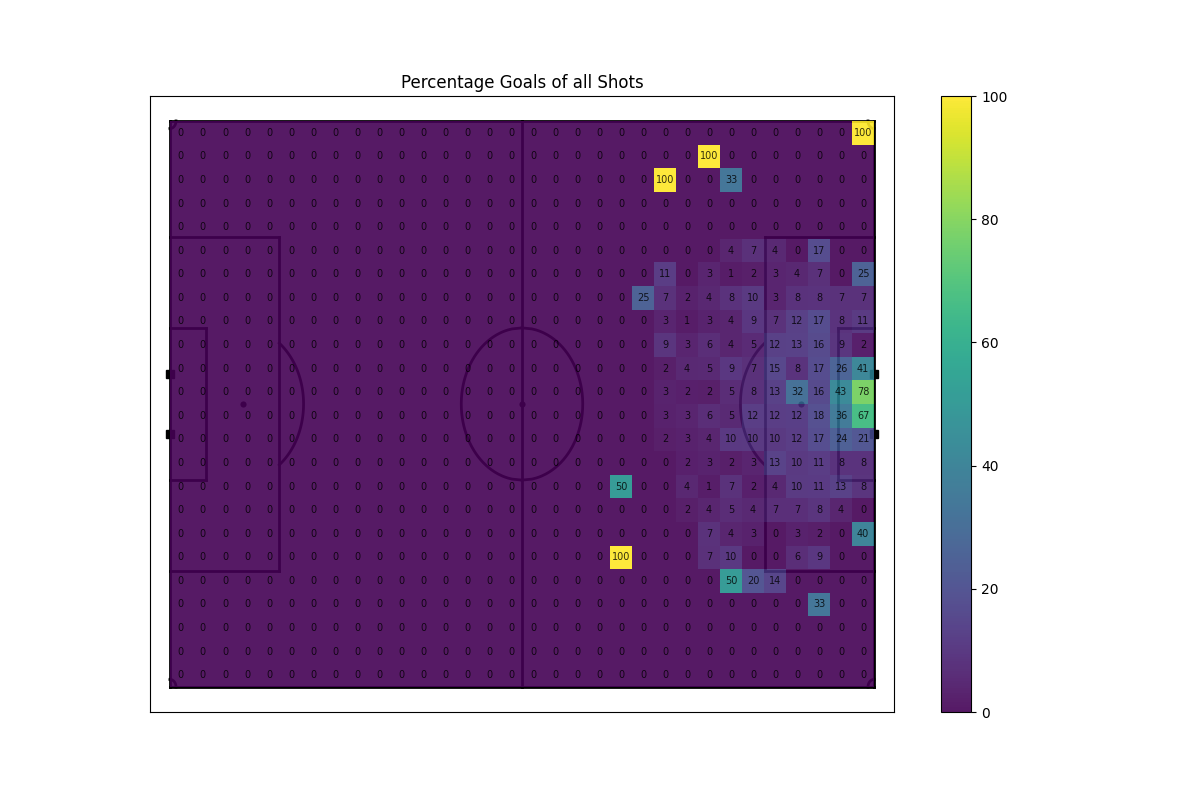

In [28]:
for title, data in zip(titles[1:3], ratios[1:3]):
    plot_results(data.ravel(), title=title, add_text=True)

As expected, shots are mainly taken from the around the box, with a bias towards the centre of the pitch. Some of the shots from far away went in, providing a 100% score for certain cells, but it is likely that this was a very specific case, not very representative for normal events. Also note the 32% success rate at the penatly spot, compared with the ~12% success rate of all cells around it. As you can imagine, the set pieces have quit a big influence and the current model. 

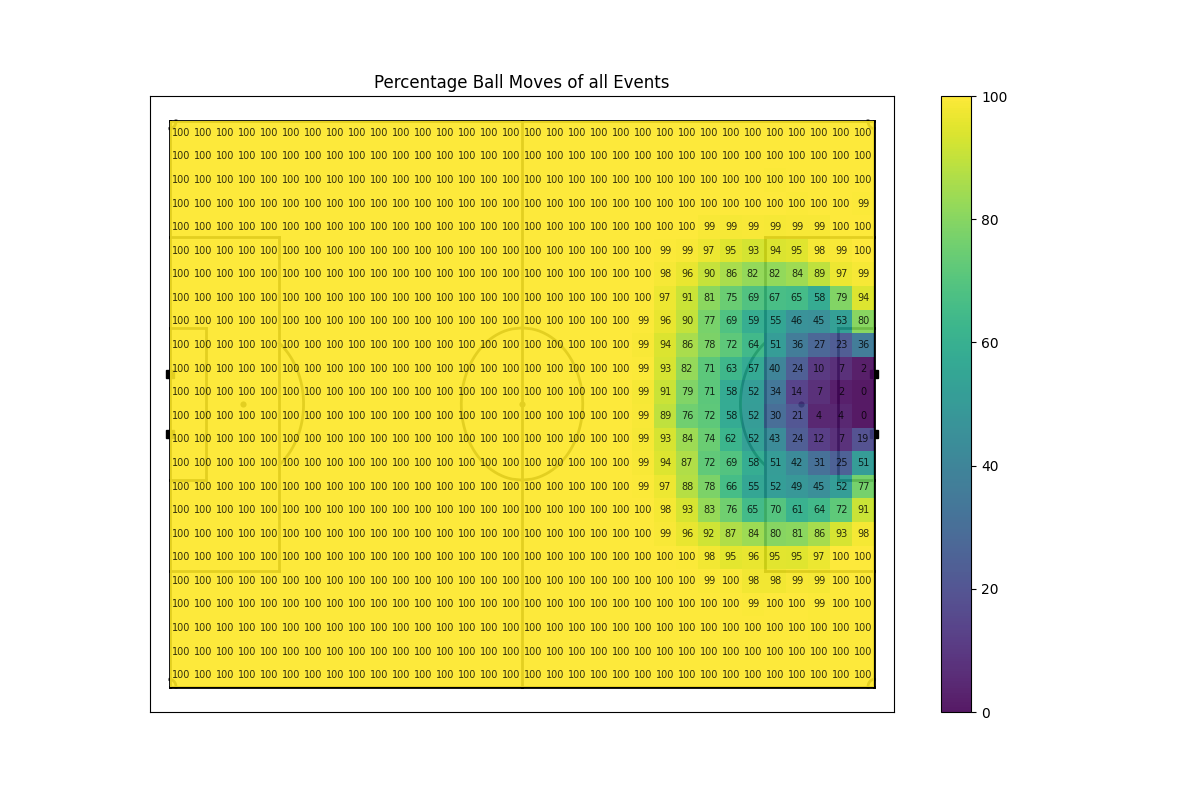

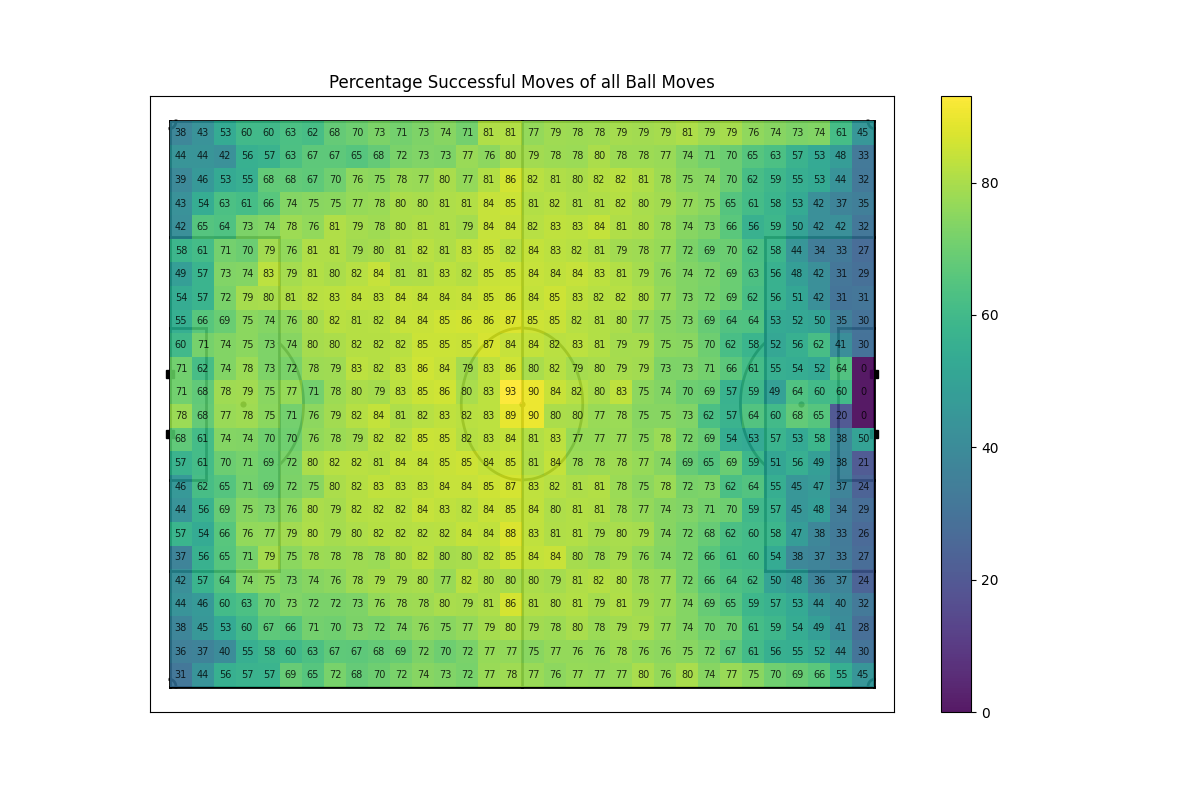

In [29]:
for title, data in zip(titles[3:], ratios[3:]):
    plot_results(data.ravel(), title=title, add_text=True)

The percentage of ball moves over all events is, of course, the inverse of the percentage of shots over all events. In general wee see a sucess rate of actions of about 80%, with higher values on ones own half, and lower values near either backline. Especially the lower success rate at ones own back line is interesting. It is likely that teams primarily get in possession there when they are highly pressured or just captured the ball and blindly shoot the ball forward (clearance) which might somethimes be labelled as a failed pass by event data providers.

## xT Defined

Expected Threat is a very intuitive idea. It basically takes the probability of shooting from a given location and multiplies it with the expected goals value, and adds the probability of moving the ball to any other location of the pitch and multiplies that times the expected threat value of that location. In a formula it looks something like this:

$ xT(x, y) = P_{shot}(x, y) * xG(x, y) + \sum \limits _{z=1} ^{x\_cells} \sum \limits _{w=1} ^{y\_cells} P_{move}(x, y -> z, w) * xT(z, w) $

Which can be simplified to:

$ xT(x, y) = P_{shot}(x, y) * xG(x, y) + P_{move} * T_{moves}(x, y) * xT $

Where $ P_{shot} $ and $ P_{move} $ are the probability of a shot and successful ball move (pass or dribble) respectively, $ xG $ is the expected goals model and $ T_{moves}(x, y) $ is, given that a move is successfull from the current position, the likelyhood of where the ball will go next.

## Creating the Transition Matrices

Now we need for every cell in the grid a transition matrix. The transition matrix holds the ratios of where a successful pass is likely to go. We ravel the grid to get an squared 2d array of N_X_BINS * N_Y_BINS by N_X_BINS * N_Y_BINS. In this loop we also fill an xG matrix, with the xG value for every cell.

In [30]:
succ_move_probs = np.zeros((N_X_BINS * N_Y_BINS, N_X_BINS * N_Y_BINS))
xg_vals = np.zeros(N_X_BINS * N_Y_BINS)

xg_model = joblib.load("../databallpy/models/xG_by_foot_pipeline.pkl")
cell_id = 0
for x_start1, x_start2 in zip(x_edges[:-1], x_edges[1:]):
    # df of all events that are within the x range
    start_df_x = df[((df["start_x"] >= x_start1) & (df["start_x"] <= x_start2))]
    for y_start1, y_start2 in zip(y_edges[:-1], y_edges[1:]):
        # df of all events that are within the x and the y range
        start_df = start_df_x[((start_df_x["start_y"] >= y_start1) & (start_df_x["start_y"] <= y_start2))]
        succ_mask = (~start_df["end_x"].isnull()) & (~start_df["end_y"].isnull()) & (start_df["event"]!="shot") & (start_df["successful"]==1)
        hist_ball_moves_succ_current_pos, _, _ = np.histogram2d(start_df.loc[succ_mask, "end_x"], start_df.loc[succ_mask, "end_y"], **params)
        current_ratio = hist_ball_moves_succ_current_pos / len(start_df)
        succ_move_probs[cell_id] = current_ratio.ravel()

        # Fill xG array
        loc = np.array([np.mean([x_start1, x_start2]), np.mean([y_start1, y_start2])])
        goal_distance = np.sqrt(np.power(X_RANGE[1] - loc[0], 2) + np.power(loc[1], 2))
        shot_angle = get_smallest_angle(loc - np.array([X_RANGE[1], 3.63]), loc - np.array([X_RANGE[1], -3.66]), angle_format="degree")
        xg_vals[cell_id] = xg_model.predict_proba(np.array([[goal_distance, shot_angle]]))[0, 1]

        cell_id += 1        

In [38]:
def get_mirrored_index(index, n_rows=N_X_BINS, n_cols=N_Y_BINS):
    x_idx = index // n_cols
    x_mean_idx = (n_rows-1) / 2 
    x_diff = np.abs(x_mean_idx - x_idx)
    if x_idx > x_mean_idx:
        x_idx -= (2*x_diff) 
    else:
        x_idx += (2*x_diff) 

    y_idx = index % n_cols
    y_mean_idx = (n_cols-1) / 2 
    y_diff = np.abs(y_mean_idx - y_idx)
    if y_idx > y_mean_idx:
        y_idx -= (2*y_diff) 
    else:
        y_idx += (2*y_diff) 

    return int(x_idx*n_cols + y_idx)

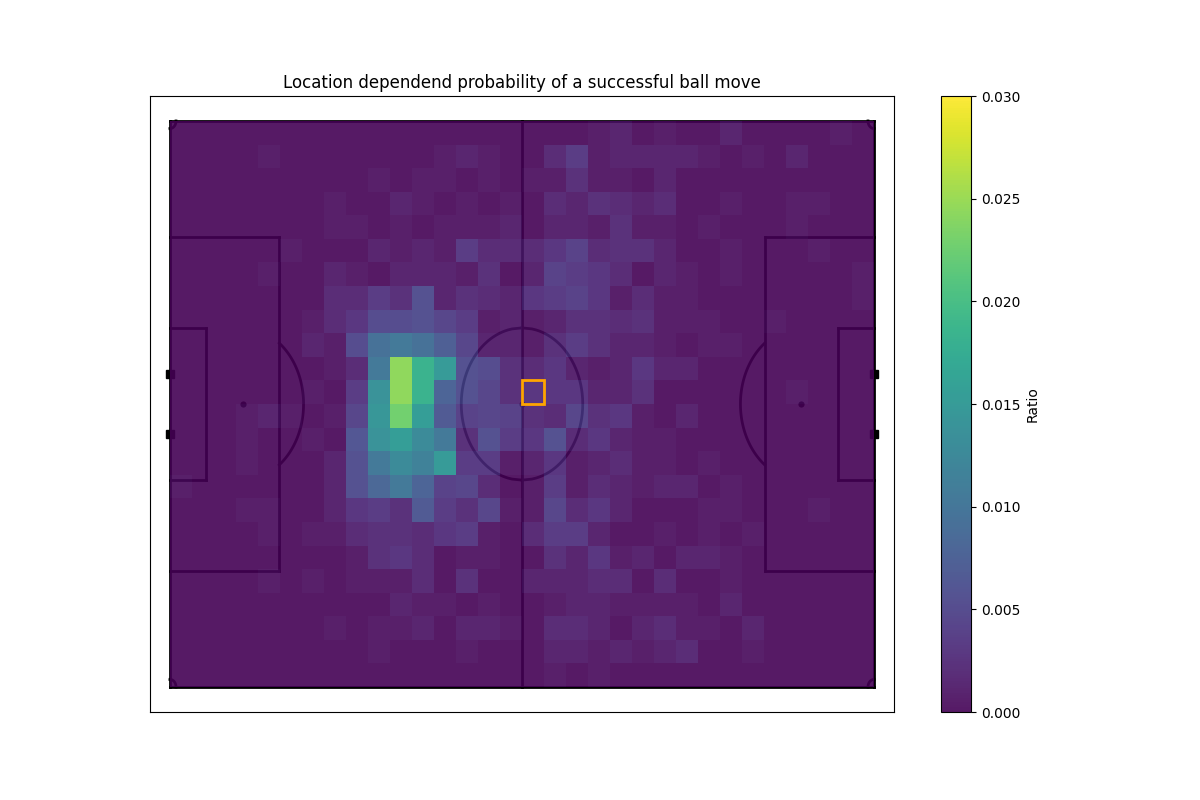

In [39]:
%matplotlib widget

box_width = (X_RANGE[1] - X_RANGE[0]) / N_X_BINS
box_height = (Y_RANGE[1] - Y_RANGE[0]) / N_Y_BINS

idx = int(N_Y_BINS * (N_X_BINS / 2) + (0.5 * N_Y_BINS))
x1 = X_RANGE[0] + (idx // N_Y_BINS) * box_width
y1 = Y_RANGE[0] + (idx % N_Y_BINS) * box_height



plt.close("all")
fig, ax = plot_soccer_pitch(pitch_color="white")
ratio = succ_move_probs[idx].reshape(N_X_BINS, N_Y_BINS)
pcm = ax.pcolormesh(x_edges, y_edges, ratio.T, cmap='viridis', alpha=0.9, vmin=0.0, vmax=0.03)
fig.colorbar(pcm, ax=ax, label="Ratio")

goal_loc = (53.0, 0)
arrow = mpatches.FancyArrowPatch((x1 + 0.5 * box_width, y1 + 0.5 * box_height), goal_loc,
                                 mutation_scale=20)
arrow.set_alpha(ratio_shots.ravel()[idx])
arrow.set_color("white")
ax.add_patch(arrow)

ax.set_title("Location dependend probability of a successful ball move")
rec = Rectangle((x1, y1), width=box_width, height=box_height, color='orange', fc='none', lw=2)
ax.add_patch(rec)
fig.canvas.draw_idle()


pitch_size = (X_RANGE[1] - X_RANGE[0], Y_RANGE[1] - Y_RANGE[0])

def on_click(event):
    if event.inaxes == ax:

        [col.remove() for col in ax.collections]
        [patch.remove() for patch in ax.patches]
        [text.remove() for text in ax.texts]
        
        x = event.xdata
        y = event.ydata
        x_idx = np.floor((x + X_RANGE[1]) / (pitch_size[0] / N_X_BINS))
        y_idx = np.floor((y + Y_RANGE[1]) / (pitch_size[1] / N_Y_BINS))
        idx = int(x_idx * N_Y_BINS + y_idx)
        ratio = succ_move_probs[idx].reshape(N_X_BINS, N_Y_BINS)
        pcm = ax.pcolormesh(x_edges, y_edges, ratio.T, cmap='viridis', alpha=0.9, vmin=0.0, vmax=0.03)
        
        x1 = X_RANGE[0] + (idx // N_Y_BINS) * box_width
        y1 = Y_RANGE[0] + (idx % N_Y_BINS) * box_height
        rec = Rectangle((x1, y1), width=box_width, height=box_height, color='orange', fc='none', lw=2)
        ax.add_patch(rec)

        mirrored_index = get_mirrored_index(idx)
        x2 = X_RANGE[0] + (mirrored_index // N_Y_BINS) * box_width
        y2 = Y_RANGE[0] + (mirrored_index % N_Y_BINS) * box_height
        rec = Rectangle((x2, y2), width=box_width, height=box_height, color='red', fc='none', lw=2)
        ax.add_patch(rec)
        
        ax.scatter([x], [y], color="black")
        
        arrow = mpatches.FancyArrowPatch((x , y), goal_loc, mutation_scale = 20)
        arrow.set_alpha(ratio_shots.ravel()[idx])
        arrow.set_color("white")
        ax.add_patch(arrow)
        
        ratio_suc_ball_move_per = int(round(ratio.sum(), 2) * 100)
        ratio_shot = int(ratio_shots.ravel()[idx] *100)
        xg = round(xg_vals[idx], 2)
        ratio_failed_ball_move = (100 - ratio_suc_ball_move_per - ratio_shot)
        
        ax.set_title(f"Ball moves: {ratio_suc_ball_move_per}%, Shots: {ratio_shot}% (xG={xg}), failed_ball_moves = {ratio_failed_ball_move}%")
        ax.axes()
            

        fig.canvas.draw_idle()
fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()

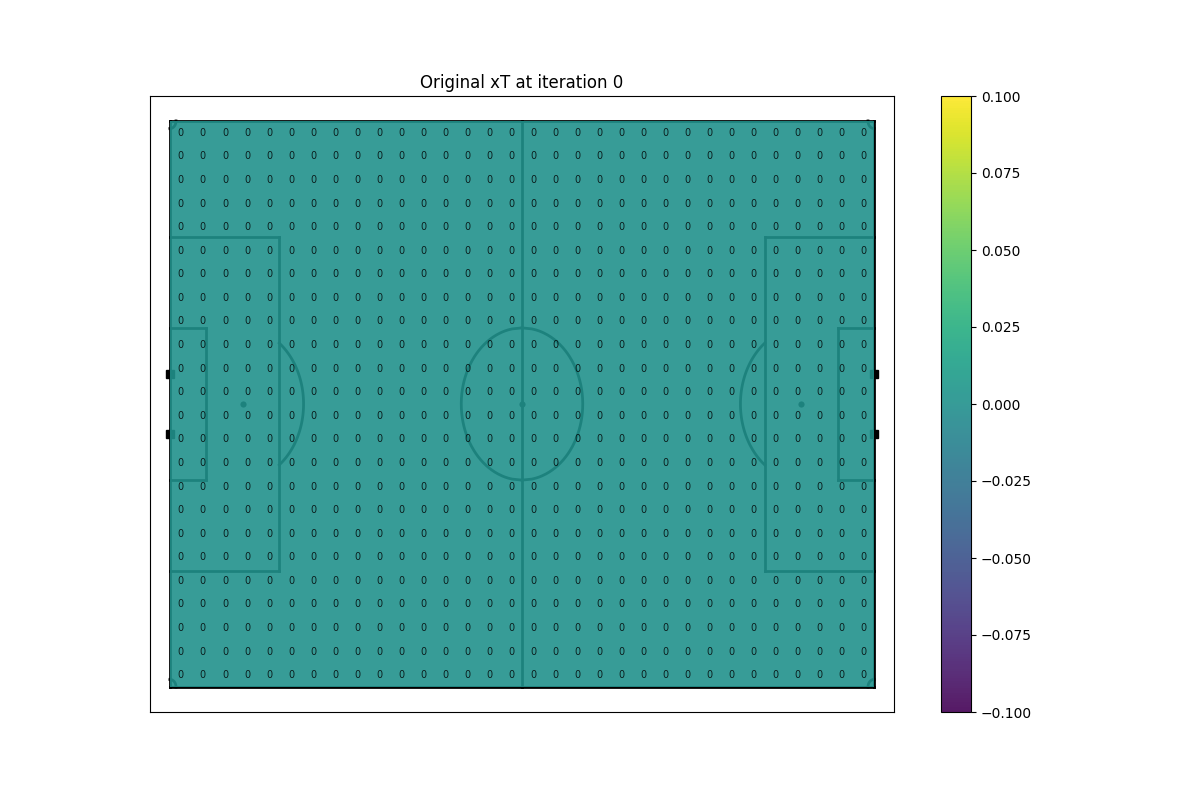

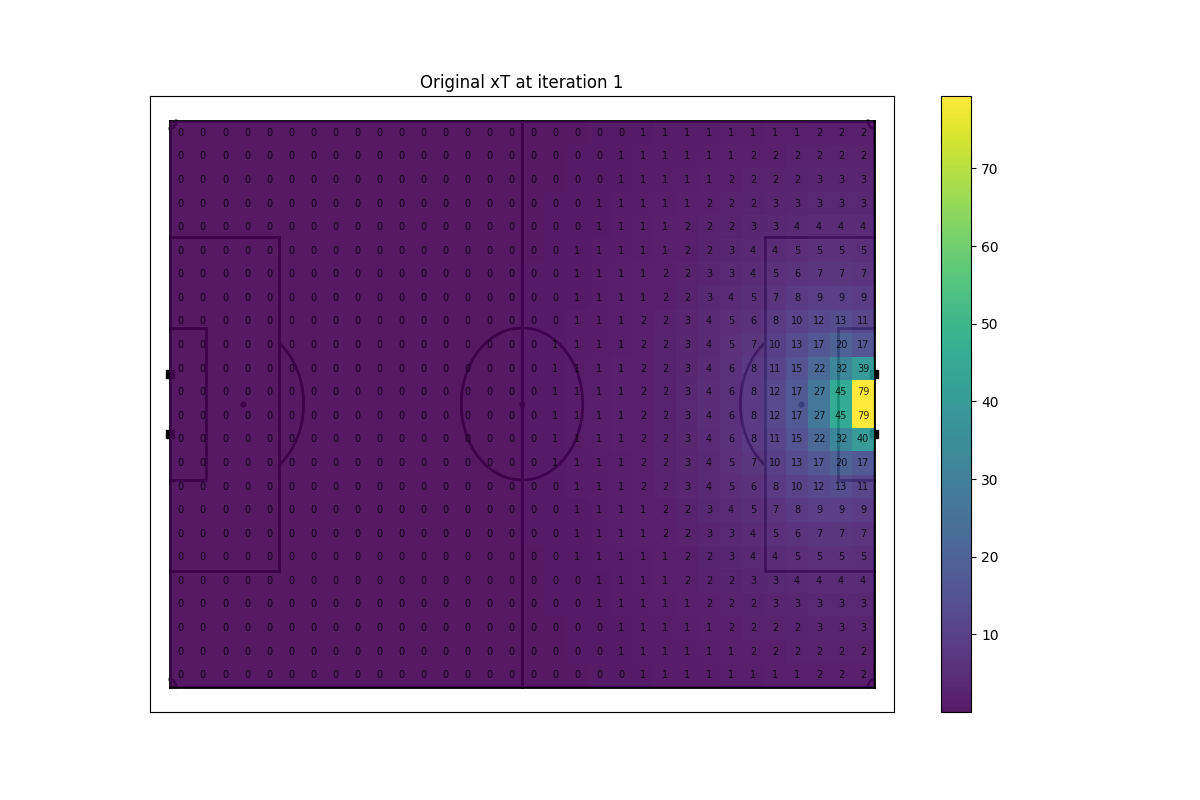

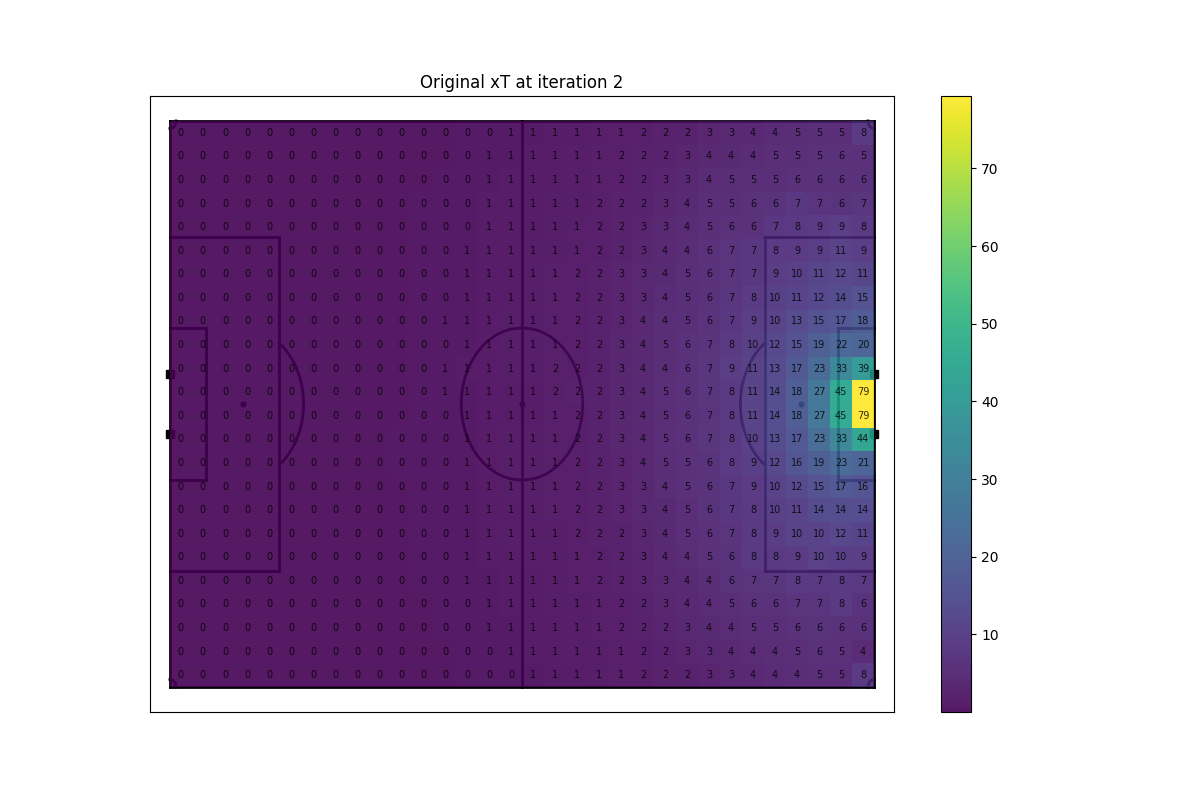

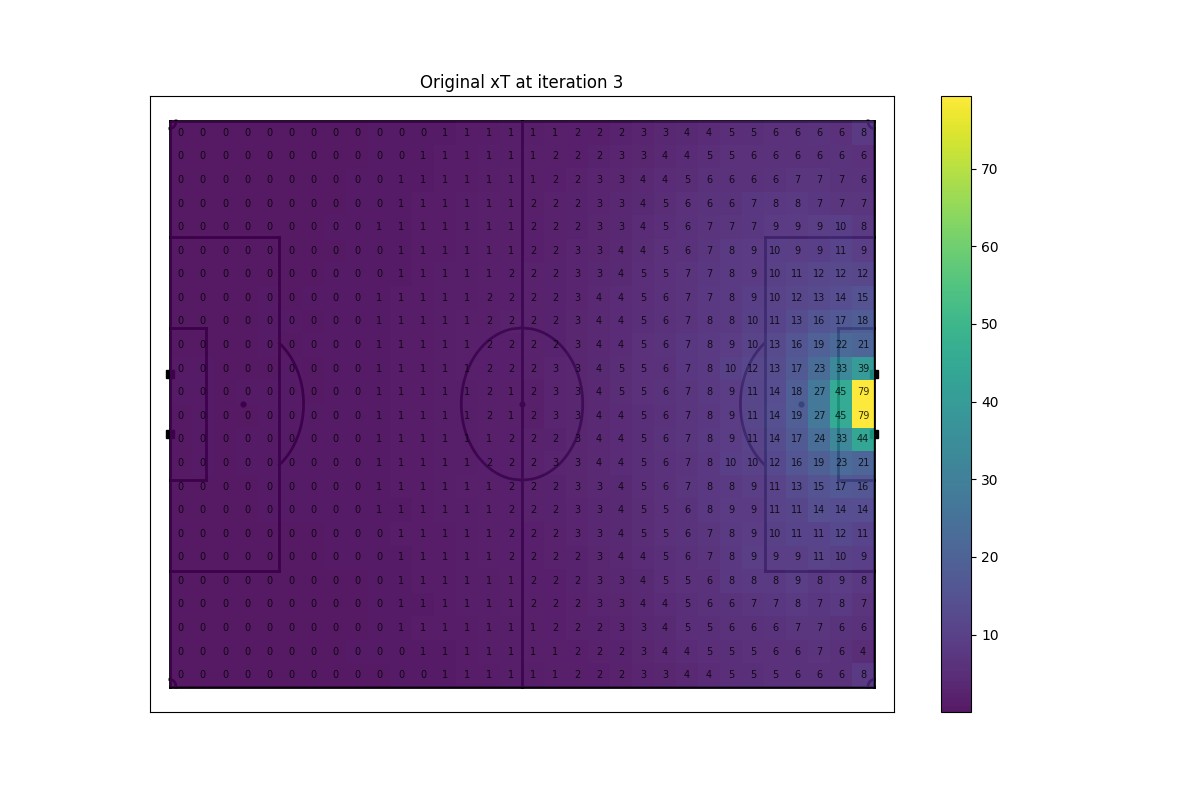

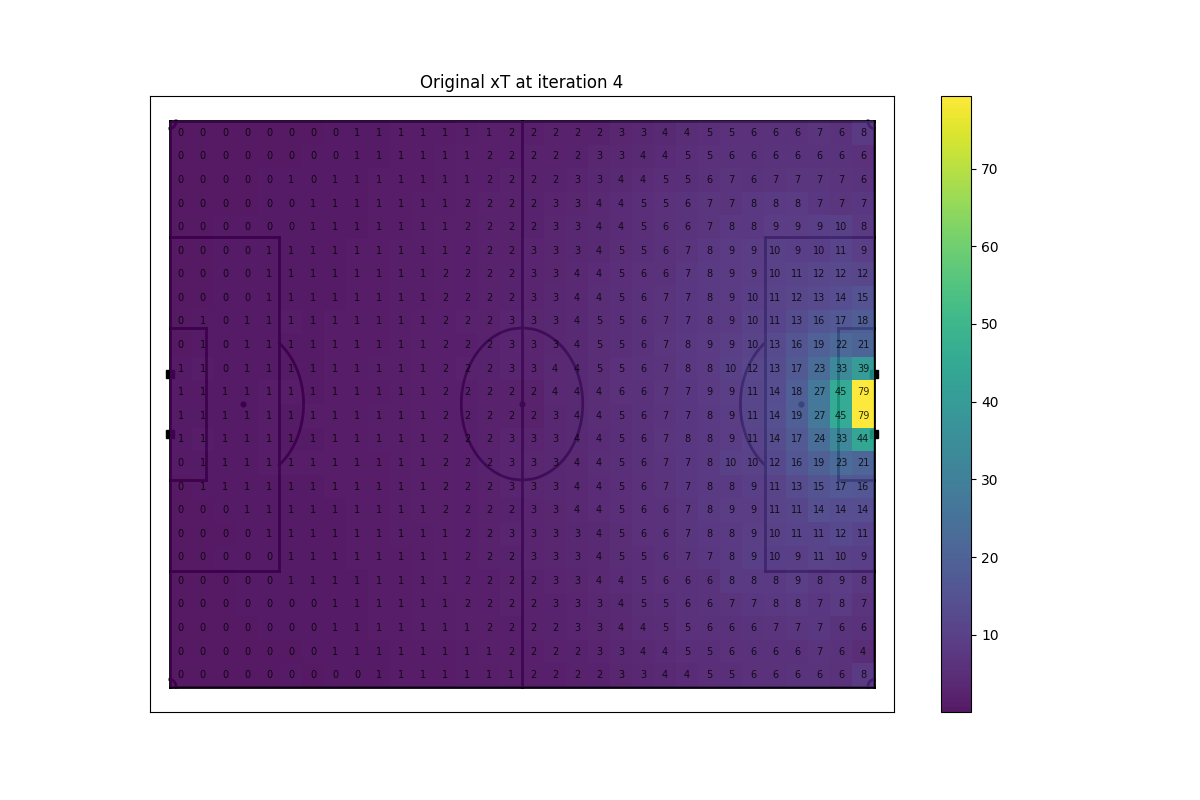

In [70]:
plt.close("all")

original_xT = np.zeros(n_x_bins * n_y_bins)
next_xT = original_xT.copy()
for i in range(5):  
    plot_results(original_xT, title=f"Original xT at iteration {i}")
    for current_cell_id in range(len(original_xT)):
        tot_xT = xg_vals[current_cell_id]
        for to_cell_id in range(len(original_xT)):
            tot_xT += succ_move_probs[current_cell_id, to_cell_id] * original_xT[to_cell_id]
        next_xT[current_cell_id] = tot_xT

    original_xT = next_xT

# plot_results(original_xT, title="Original xT")

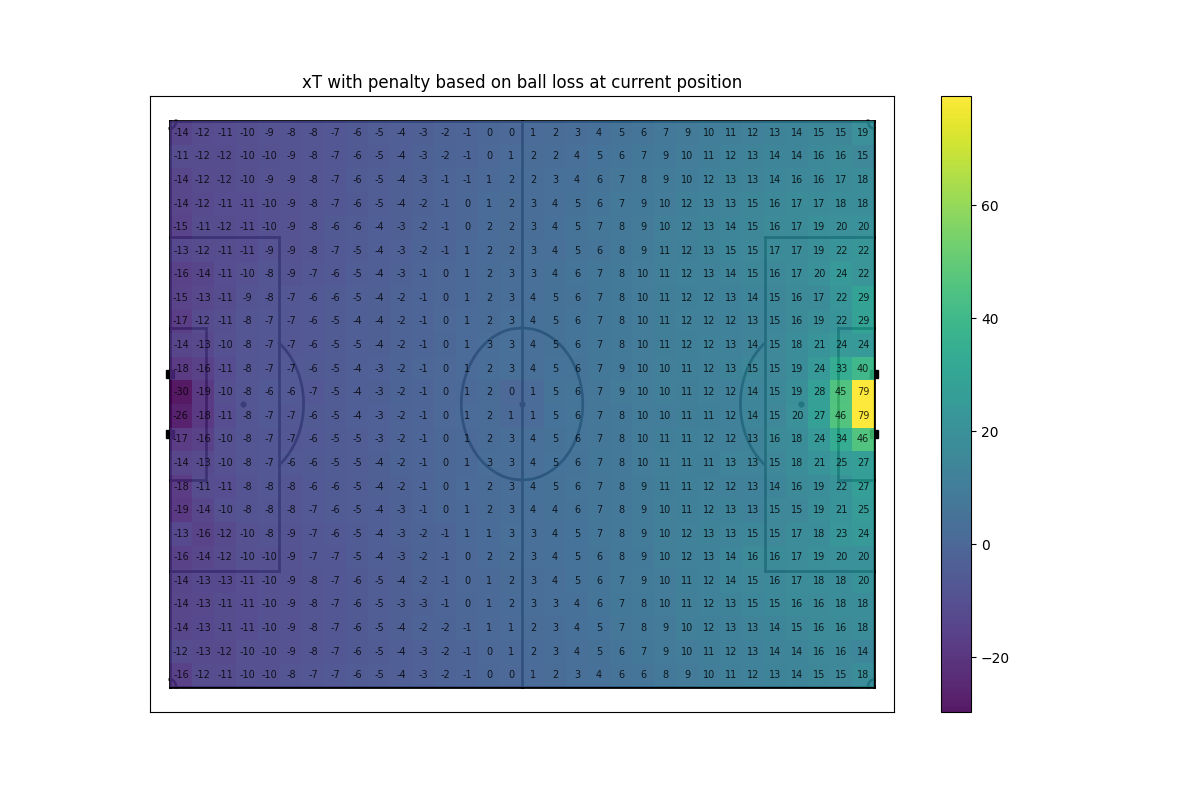

In [71]:
plt.close("all")

xT_position_penalty = np.zeros(n_x_bins * n_y_bins)
next_xT = xT_position_penalty.copy()

for i in range(7):     
    for current_cell_id in range(len(xT_position_penalty)):
        ratio_suc_ball_move = succ_move_probs[current_cell_id].sum()
        ratio_shot = ratio_shots.ravel()[current_cell_id]
        ratio_failed = 1 - ratio_suc_ball_move - ratio_shot

        tot_xT = xg_vals[current_cell_id] - (ratio_failed * xT_position_penalty[get_mirrored_index(current_cell_id)])
        for to_cell_id in range(len(xT_position_penalty)):
            tot_xT += succ_move_probs[current_cell_id, to_cell_id] * xT_position_penalty[to_cell_id]
        next_xT[current_cell_id] = tot_xT

    xT_position_penalty = next_xT

plot_results(xT_position_penalty, title="xT with penalty based on ball loss at current position")

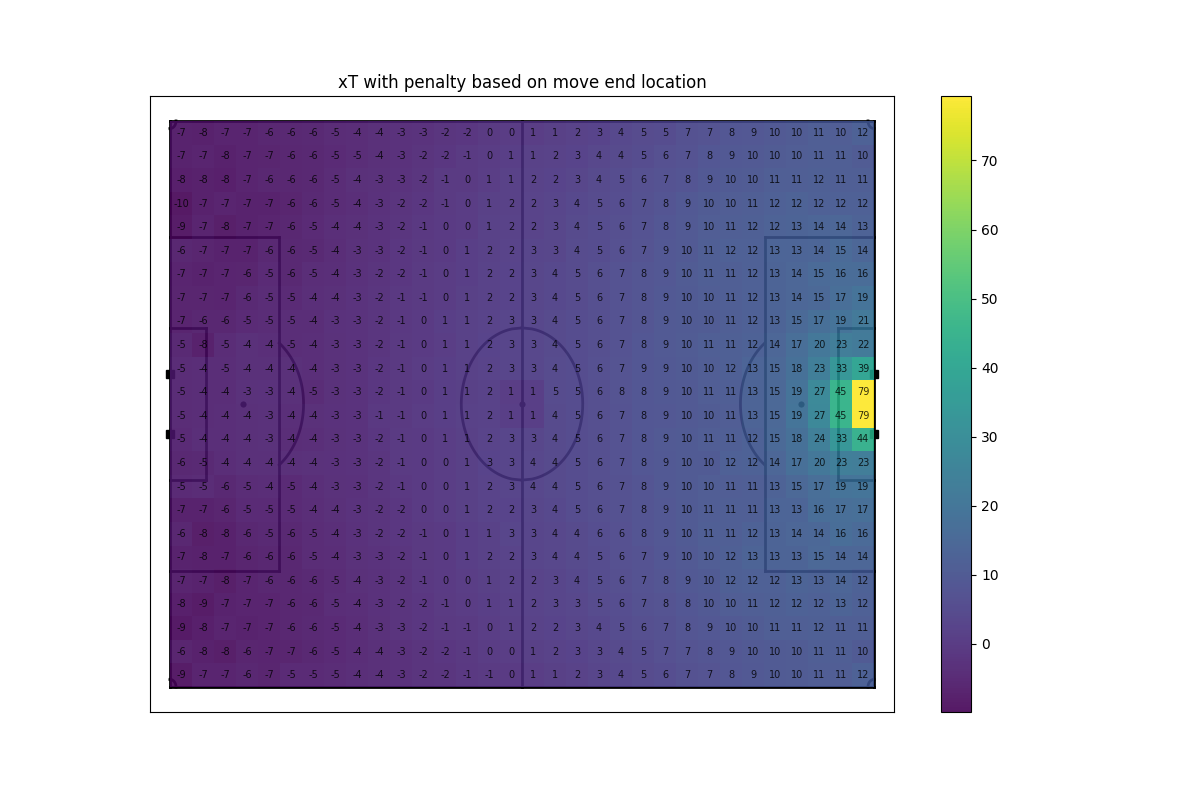

In [72]:
plt.close("all")

xT_next_position_penalty = np.zeros(n_x_bins * n_y_bins)
next_xT = xT_next_position_penalty.copy()

for i in range(5):     
    for current_cell_id in range(len(xT_next_position_penalty)):
        prob_succ_ball_move = succ_move_probs[current_cell_id].sum()
        prob_shot = ratio_shots.ravel()[current_cell_id]
        prob_failed_move = 1 - prob_succ_ball_move - prob_shot
        
        tot_xT = xg_vals[current_cell_id] 
        for to_cell_id in range(len(xT_next_position_penalty)):
            prob_current_ball_move = np.divide(succ_move_probs[current_cell_id, to_cell_id], prob_succ_ball_move, where=prob_succ_ball_move!=0)
            tot_xT += (succ_move_probs[current_cell_id, to_cell_id] * xT_next_position_penalty[to_cell_id])
            tot_xT -= (prob_current_ball_move*prob_failed_move * xT_next_position_penalty[get_mirrored_index(to_cell_id)])
        next_xT[current_cell_id] = tot_xT

    xT_next_position_penalty = next_xT
    
plot_results(xT_next_position_penalty, title="xT with penalty based on move end location")

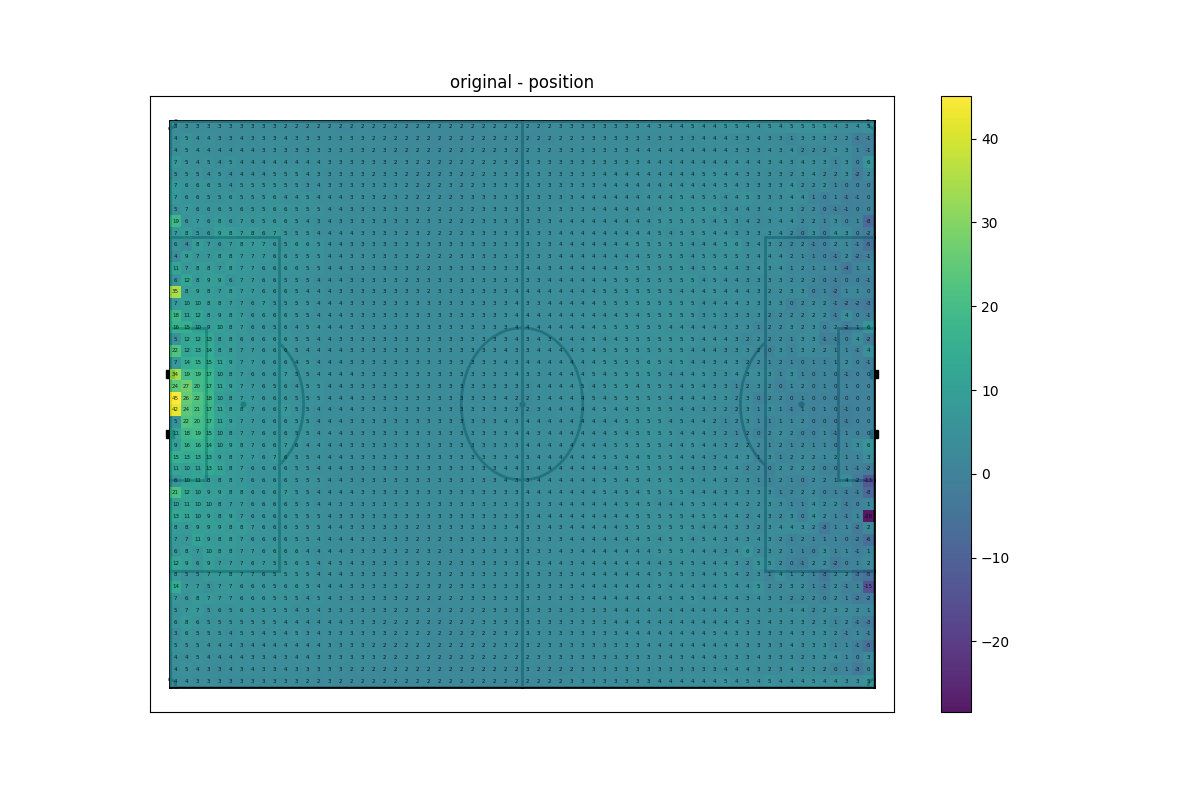

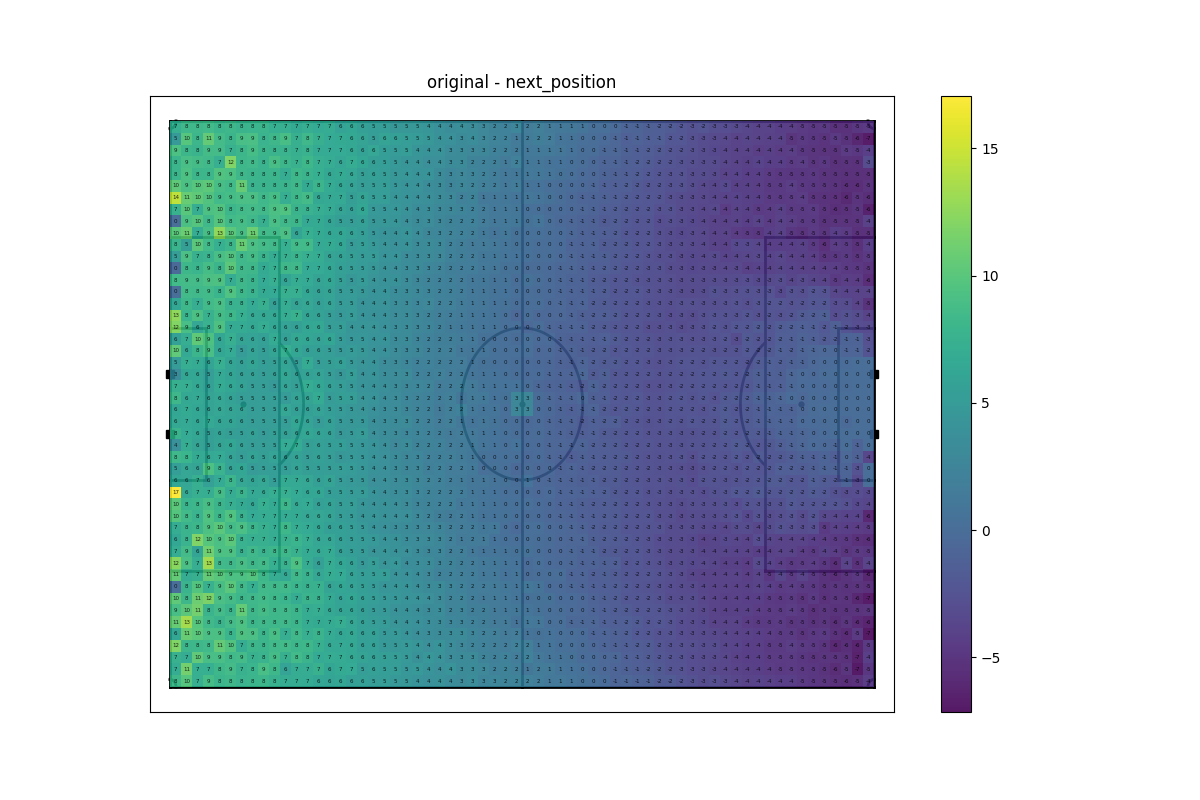

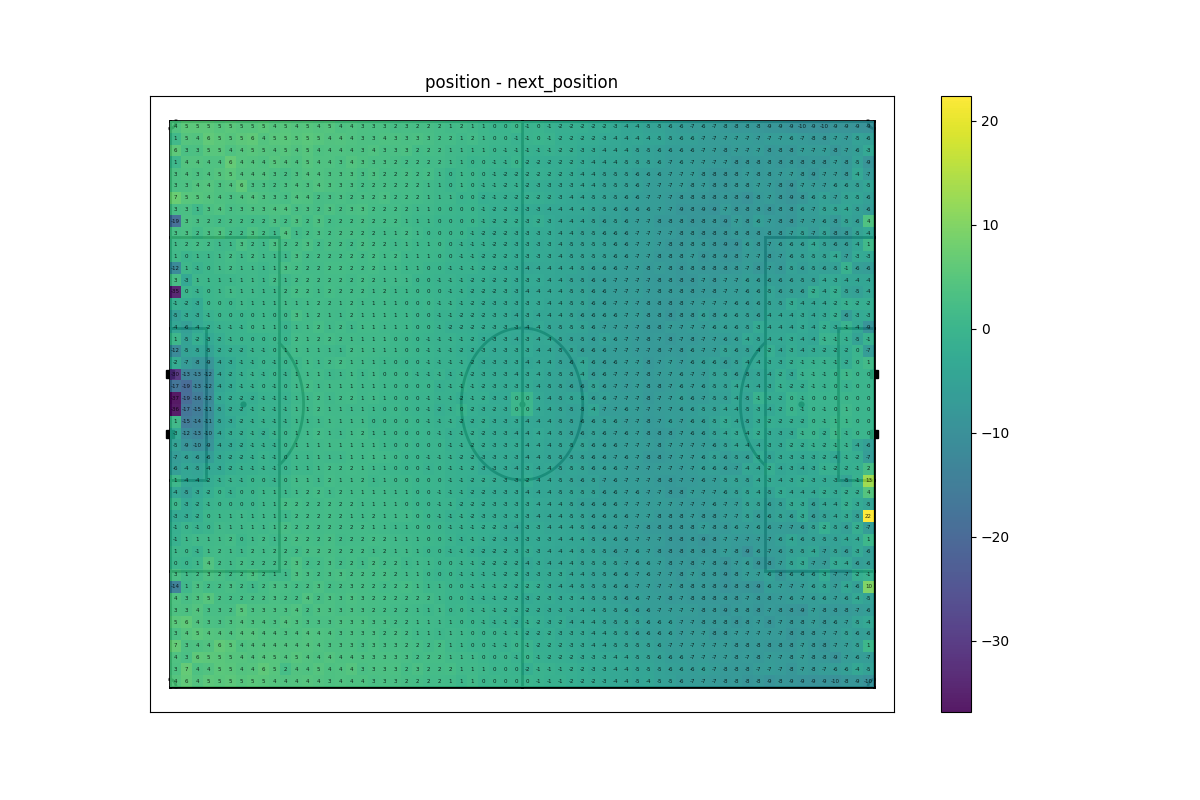

In [191]:
plot_results(original_xT - xT_position_penalty, title="original - position")
plot_results(original_xT - xT_next_position_penalty, title="original - next_position")
plot_results(xT_position_penalty - xT_next_position_penalty, title="position - next_position")